# Unesco authority matching

We have a lot of person authorities from the Unesco Index Translationum dump. By manually refining our person-contributors list we could already link a Unesco authority to KBR: if we sure two authorities are the same, adding the Unesco identifier in the unesco column of the corresponding BELTRANS authority and if necessary remove the line with the authority that only has the Unesco identifier.

However as this is a very manual task we are interested in a more automatic approach. Names are not unique thus we cannot simply merge on the name value alone. However, **additionally we can look into related books**. If one or more books of the BELTRANS authority have a similar title to one or more books of a Unesco authority they are probably the same person. In this case we do not have to care much if the books have different publication years, as our main focus is the merging of the authorities. 

In [1]:
import sys
import os
sys.path.insert(1, os.pardir)
from tools.sparql import utils_sparql
import pandas as pd
import matching_utils
import json
import statistics
from dotenv import load_dotenv
from lookup import MatchingLookup
load_dotenv()
endpoint = os.environ.get('ENV_SPARQL_ENDPOINT_INTEGRATION')
from tqdm import tqdm



The following lists all variables for the computation such as values and input / output files

In [2]:
downloadAgain = True

# output directory for matching results and stats
# commented line is the initial output directory with results of different configurations for comparison (took a while to create)
#outputDirectory = 'unesco-matching-scores'
outputDirectory = '2023-08-09_matching-scores'
if not os.path.exists(outputDirectory):
    os.makedirs(outputDirectory) 
statsFilename = os.path.join(outputDirectory, 'matching-stats.csv')

# already cached authority data for matching (will be overwritten when downloadAgain is True)
beltransAuthorityDataCSVFile = os.path.join(outputDirectory, 'beltrans-authority-data.csv')
unescoAuthorityDataCSVFile = os.path.join(outputDirectory, 'unesco-authority-data.csv')

# in case downloadAgain is True, the following query is used to get BELTRANS authority data
beltransSPARQLQueryFile = "sparql-queries/get-contributor-merging-info-without-unesco.sparql"
# alternatively only BELTRANS contributors without Unesco (around 3k)
#beltransSPARQLQueryFile = "sparql-queries/get-contributor-merging-info-without-unesco-beltrans.sparql"

# in case downloadAgain is True, the following query i sused to get Unesco authority data
unescoSPARQLQueryFile = "sparql-queries/get-contributor-merging-info-unesco-unknown.sparql"

# Used algorithms and similarity thresholds (the more the longer it takes)
# initially the following values were used for comparison (plots of result stats were used to determine the best)
#algorithms = ['partial_ratio', 'token_sort_ratio', 'token_set_ratio']
#similarityThresholds = [95, 90, 80]

# after testing we found token_sor_ratio the best, a similarity of 90 was sufficient
algorithms = ['token_sort_ratio']
similarityThresholds = [90]
minTitleMatches = 1

## Get BELTRANS authority data + related books
We query the BELTRANS SPARQL endpoint to retrieve contributors and related book titles.
When querying only contributors that are part of the BELTRANS corpus we get `3,615` contributors, when querying all contributors of integrated data we have about translations NL-FR/FR-NL 1970-2020 we get `13,943` contributors.
Especially the latter query takes a bit, thus we store the query result and only download it again when necessary. This can be indicated by setting the `downloadAgain` variable from the code block above to True.

In [3]:
if downloadAgain:
    # perform SPARQL query and store the result either directly in a dataframe and save as csv file
    beltransAuthorityData = utils_sparql.queryToDataframe(endpoint, beltransSPARQLQueryFile, indexCol="contributorID")
    beltransAuthorityData.to_csv(beltransAuthorityDataCSVFile)
else:
    # read the already cached data (from a previous run)
    beltransAuthorityData = pd.read_csv(beltransAuthorityDataCSVFile, index_col='contributorID')
print(f'Successfully retrieved {beltransAuthorityData.shape[0]} persons')

	Processing query sparql-queries/get-contributor-merging-info-without-unesco.sparql
Successfully retrieved 13943 persons


In [4]:
beltransAuthorityData

,contributorName,alternateNames,titles
contributorID,,,
2150,Derib,"Ribaupierre, Claude de",Yakari en de valstrik;Yakari en de gevorkte ho...
3548,"Jacobs, Edgar P.","Jacob, Edgard Félix Pierre",Het geheim van de Zwaardvis;De 3 formules van ...
5119,"Peyo,","Culliford, Pierre",De leerlingsmurf ; Smurfenvallen ; Smurfen in ...
5346,"Ray, Jean","De Kremer, Reimond;Cremer, Raymond de;Рей, Жа...","De zwarte schaduw;Wel te rusten, Sir Gaunt !;S..."
4330,"Magda,","Seron, Magda;Tumak;Ginesta, Magda",Gulliver chez les Lilliputiens ; Alice au pays...
...,...,...,...
7a79a0d8-282c-4718-a333-9ad78b608f92,Marthe Seguin-Fontès,NaN,Poppenweelde
82489ea8-9579-4957-b332-cea86b58a69a,Jan de Hartog,NaN,Le ciel de lit : pièce en 3 actes
864c52ce-e1eb-4b7d-aba1-780faeae3dd8,José de Broucker,NaN,Het dossier Suenens : diagnose van een crisis


## Get Unesco authority data + related books

In [7]:
if downloadAgain:
    unescoAuthorityData = utils_sparql.queryToDataframe(endpoint, unescoSPARQLQueryFile, indexCol="contributorUnescoID")
    unescoAuthorityData.to_csv(unescoAuthorityDataCSVFile)
else:
    unescoAuthorityData = pd.read_csv(unescoAuthorityDataCSVFile, index_col="contributorUnescoID")
    
print(f'Successfully retrieved {unescoAuthorityData.shape[0]} persons')

	Processing query sparql-queries/get-contributor-merging-info-unesco-unknown.sparql
Successfully retrieved 339 persons


In [8]:
unescoAuthorityData = unescoAuthorityData.applymap(str)
unescoAuthorityData

,contributorUnescoIDLong,contributorName,titles
contributorUnescoID,,,
u1877,u30eb427e4cb4e5404579d7efd2e8a8bd,Saint-John Perse,Anabasis
u5737,u62a241c146411b7e2f4765be7d16a63e,Pema Wangyal,Diamanten van wijsheid
u9371,ub01d038d5ef2a724d369bbfa44301c24,Def,Digital nation
u9693,u54d40486f6740744b48dcf2e57ffeafb,Moynot,Anatomie van de wanorde
u9695,uab6f603e07f1bf22bf019440f64cb81d,Zeno Texts,Valérie
...,...,...,...
u8035,ua1564baa466364409358c6584d4538e0,Šri-Ma of Pondicherry,Het Goddelijke binnen je bereik: gesprekken me...
u9707,u72efd0469ab363db426d6a4ee8214070,Bédu,Clifton special;De Witte Schaduw : een verhaal...
u10287,u600f234cca18f91e476a7cd857990e62,Rupena,De schilder & de wilde zwanen : een verhaal va...


## Perform the matching

This matching is performed by (additionally) comparing the similarity of book titles linked to an authority).

In [9]:
beltransAuthorityData = beltransAuthorityData.applymap(str)
beltransAuthorityData['index'] = beltransAuthorityData.index
beltransAuthorityData

,contributorName,alternateNames,titles,index
contributorID,,,,
2150,Derib,"Ribaupierre, Claude de",Yakari en de valstrik;Yakari en de gevorkte ho...,2150
3548,"Jacobs, Edgar P.","Jacob, Edgard Félix Pierre",Het geheim van de Zwaardvis;De 3 formules van ...,3548
5119,"Peyo,","Culliford, Pierre",De leerlingsmurf ; Smurfenvallen ; Smurfen in ...,5119
5346,"Ray, Jean","De Kremer, Reimond;Cremer, Raymond de;Рей, Жа...","De zwarte schaduw;Wel te rusten, Sir Gaunt !;S...",5346
4330,"Magda,","Seron, Magda;Tumak;Ginesta, Magda",Gulliver chez les Lilliputiens ; Alice au pays...,4330
...,...,...,...,...
7a79a0d8-282c-4718-a333-9ad78b608f92,Marthe Seguin-Fontès,nan,Poppenweelde,7a79a0d8-282c-4718-a333-9ad78b608f92
82489ea8-9579-4957-b332-cea86b58a69a,Jan de Hartog,nan,Le ciel de lit : pièce en 3 actes,82489ea8-9579-4957-b332-cea86b58a69a
864c52ce-e1eb-4b7d-aba1-780faeae3dd8,José de Broucker,nan,Het dossier Suenens : diagnose van een crisis,864c52ce-e1eb-4b7d-aba1-780faeae3dd8


In [10]:
lookupObject = MatchingLookup()
beltransAuthorityData.apply(
    lambda row: lookupObject.addLookupRecord(row['index'], 
                                             row['contributorName'].split(';') + row['alternateNames'].split(';'), 
                                             row['titles'].split(';')), 
    axis=1)
print('Lookup object created!')

Lookup object created!


In [11]:
allStats = {}
stats = {'no-name-candidates': 0, 
         'more-than-one-name-candidate': 0, 
         'one-name-candidate': 0,
         'one-authority-match-via-title': 0,
         'more-than-one-authority-match-via-title': 0,
         'number-name-candidates': []}

In [12]:
if not os.path.exists(outputDirectory):
    os.makedirs(outputDirectory)
for alg in algorithms:
    for threshold in similarityThresholds:
        outputFilename = os.path.join(outputDirectory, f'candidates-{alg}-{threshold}.csv')
        outputFilenameClearMatches = os.path.join(outputDirectory, f'clear-matches-{alg}-{threshold}.csv')
        outputFilenameMultipleMatches = os.path.join(outputDirectory, f'multiple-matches-{alg}-{threshold}.csv')
        outputFilenameOneMatchOneDiscarded = os.path.join(outputDirectory, f'one-match-one-discarded-{alg}-{threshold}.csv')
        outputStatsFilename = os.path.join(outputDirectory, f'stats-{alg}-{threshold}.json')
        df = unescoAuthorityData.copy()
        statsKey = f'{alg}-{threshold}'
        allStats[statsKey] = stats.copy()
        tqdm.pandas(desc=f'Matching via {alg} and threshold {threshold}')
        df[['candidatesID', 'candidatesName', 'discardedCandidateIDs', 'discardedCandidateNames']] = \
  df.progress_apply(
    lambda row: matching_utils.findMatches(row, 
                                           lookupObject, 
                                           allStats[statsKey],
                                           simAlgorithmNames=alg,
                                           simThresholdNames=threshold,
                                           simAlgorithmTitles=alg,
                                           simThresholdTitles=threshold, 
                                           minTitleMatches=minTitleMatches), 
    axis=1)
        
        dfData = df.applymap(str)
        dfData = dfData.fillna('')
        dfData['index'] = dfData.index
        clearMatches = dfData.loc[(dfData['discardedCandidateIDs'] == '') 
                          & (~dfData['candidatesID'].str.contains(';')) 
                          & (dfData['candidatesID'] != '')]
        clearMatches.to_csv(outputFilenameClearMatches)
        
        oneMatchOneDiscarded = dfData.loc[(dfData['discardedCandidateIDs'] != '') 
                          & (~dfData['candidatesID'].str.contains(';')) 
                          & (dfData['candidatesID'] != '')]
        oneMatchOneDiscarded.to_csv(outputFilenameOneMatchOneDiscarded)
        
        multipleMatches = dfData.loc[(dfData['candidatesID'].str.contains(';')) 
                          & (dfData['candidatesID'] != '')]
        multipleMatches.to_csv(outputFilenameMultipleMatches)
        
        dfData.to_csv(outputFilename)
        
        # write stats of current run to a separate file (writing the stats of all runs comes later)
        with open(outputStatsFilename, 'w') as statsOut:
            statsOut.write(json.dumps(allStats[statsKey], indent=2))


Matching via token_sort_ratio and threshold 90: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:29<00:00, 11.36it/s]


In [13]:
clearMatches = dfData.loc[(dfData['discardedCandidateIDs'] == '') 
                          & (~dfData['candidatesID'].str.contains(';')) 
                          & (dfData['candidatesID'] != '')]
clearMatches.shape[0]
clearMatches.to_csv(os.path.join(outputDirectory, f'clear-matches-token_sort_ratio-90.csv'))

In [14]:
oneMatchOneDiscarded = dfData.loc[(dfData['discardedCandidateIDs'] != '') 
                          & (~dfData['candidatesID'].str.contains(';')) 
                          & (dfData['candidatesID'] != '')]
oneMatchOneDiscarded.shape[0]
oneMatchOneDiscarded.to_csv(os.path.join(outputDirectory, f'one-match-one-discarded-token_sort_ratio-90.csv'))

In [15]:
multipleMatches = dfData.loc[(dfData['candidatesID'].str.contains(';')) 
                          & (dfData['candidatesID'] != '')]
multipleMatches.to_csv(os.path.join(outputDirectory, f'multiple-matches-token_sort_ratio-90.csv'))
multipleMatches.shape[0]

0

In [16]:
processedStats = {}
for key,stats in allStats.items():
    print(key)
    processedStats[key] = {}
    for var in stats:
        if var == 'number-name-candidates':
            print(f'\t{var}: {statistics.median(stats[var])}')
            processedStats[key]['number-name-candidates-median'] = statistics.median(stats[var])
            processedStats[key]['number-name-candidates-max'] = max(stats[var])
        else:
            print(f'\t{var}: {stats[var]}')
            processedStats[key][var] = stats[var]

token_sort_ratio-90
	no-name-candidates: 208
	more-than-one-name-candidate: 13
	one-name-candidate: 118
	one-authority-match-via-title: 63
	more-than-one-authority-match-via-title: 0
	number-name-candidates: 1


In [17]:
statsDf = df.from_dict(processedStats)

In [18]:
statsDf

,token_sort_ratio-90
more-than-one-authority-match-via-title,0
more-than-one-name-candidate,13
no-name-candidates,208
number-name-candidates-max,3
number-name-candidates-median,1
one-authority-match-via-title,63
one-name-candidate,118


In [19]:
statsDf.to_csv(statsFilename)

In [20]:
#statsDfRaw = pd.read_csv('unesco-matching-scores/bak-stats.csv')
statsDfRaw = pd.read_csv(statsFilename)

In [21]:
statsDfJSON = json.loads(statsDfRaw.to_json(orient='records'))

In [22]:
formattedJSON = []
for varDict in statsDfJSON:
    measurement = varDict['Unnamed: 0']
    for varName,varValue in varDict.items():
        newRow = {}
        if not varName.startswith('Unnamed'):
            nameParts = varName.split('-')
            newRow['alg'] = nameParts[0]
            newRow['threshold'] = nameParts[1]
            newRow['value'] = varValue
            newRow['var'] = measurement
            formattedJSON.append(newRow)

In [23]:
statsDf = pd.DataFrame(formattedJSON)

In [24]:
statsDf

,alg,threshold,value,var
0,token_sort_ratio,90,0,more-than-one-authority-match-via-title
1,token_sort_ratio,90,13,more-than-one-name-candidate
2,token_sort_ratio,90,208,no-name-candidates
3,token_sort_ratio,90,3,number-name-candidates-max
4,token_sort_ratio,90,1,number-name-candidates-median
5,token_sort_ratio,90,63,one-authority-match-via-title
6,token_sort_ratio,90,118,one-name-candidate


<AxesSubplot:xlabel='alg'>

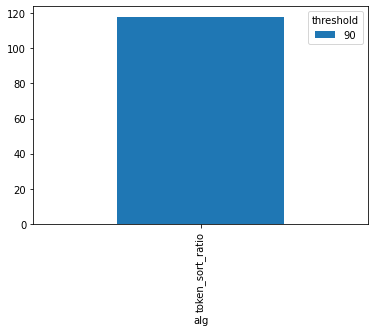

In [25]:
statsDfOneCandidate = statsDf[statsDf['var']=='one-name-candidate']
statsDfOneCandidate.pivot(index='alg', columns='threshold', values='value').plot(kind='bar')

<AxesSubplot:xlabel='alg'>

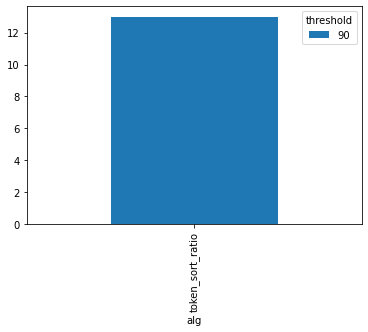

In [26]:
statsDfMultipleCandidates = statsDf[statsDf['var']=='more-than-one-name-candidate']
statsDfMultipleCandidates.pivot(index='alg', columns='threshold', values='value').plot(kind='bar')

<AxesSubplot:xlabel='alg'>

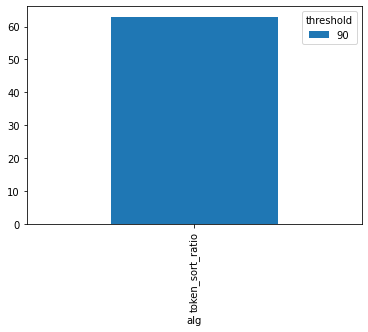

In [27]:
statsDfOneTitle = statsDf[statsDf['var']=='one-authority-match-via-title']
statsDfOneTitle.pivot(index='alg', columns='threshold', values='value').plot(kind='bar')

<AxesSubplot:xlabel='alg'>

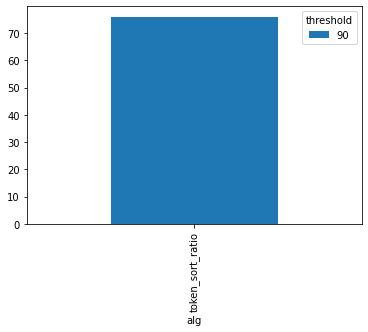

In [37]:
statsDfMultipleTitles = statsDf[statsDf['var']=='more-than-one-authority-match-via-title']
statsDfMultipleTitles.pivot(index='alg', columns='threshold', values='value').plot(kind='bar')

## Stats from initial run to compare different values
We compared the algorithms `['partial_ratio', 'token_sort_ratio', 'token_set_ratio']` and the similarity values `[95, 90, 80]`.

### token_sort_ratio, similarity 90

There are `3,204` from `8,327` rows with *at least one* candidate. From those, `3,128` are single matches (filtered in a spreadsheet with does not contain a semicolon).
There are also matches with switched first name and last name. We already anticipated that the token_sort algorithm will be a good choice for person authority names.
Examples are:
* `Kors, Magriet`  and `Magriet Kors`
* `Abeele, Andries van den`  and `Van den Abeele, Andries` (it was not confused with `Abeele, Erik van den`), but we also had an additional check based on common book titles

There are `142` that additionally have at least one discarded identifier. 
For example in one case, `Rie van Antwerpen`  was matched with `Van Antwerpen Rie` and the match with `Van Antwerpen Piet` was discarded. This seems legist.
But there are also cases such as `Anouilh, Jean` that was matched with `Jean anouilh` and the discarded match with `anouilh jean`, the latter two seem to be duplicates in our authority data.

### partial_ratio, similarity 90
There are `2,312` from `8,327` rows with *at least one* candidate. From those, `2,264` are single matches (filtered in a spreadsheet with "does not contain" semicolon).
Matches such as `Abeele, Andries van den` described above are not in the result.
Also not `Aaron Soazig` and `Soazig Aaron`.